In [1]:
%matplotlib inline
from __future__ import division
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import math
from adjustText import adjust_text

import common
import notebook_helpers

FS = (10, 7)

LOG = 1

om = notebook_helpers.get_frame()
lyrs = lyr = notebook_helpers.get_frame(having_lyrics=True)

# Lalalalala: Measuring Repetition in Pop Music

In 1977, computer science icon Donald Knuth published a facetious paper called [The Complexity of Songs](https://en.wikipedia.org/wiki/The_Complexity_of_Songs). In it, he used the language of complexity theory to analyze the space complexity of popular songs - i.e. for some family of songs, how much space do you need to describe one of those songs, and how does that number change as the song's length goes to infinity?

The running joke is that, over time, songwriters have worked to invent increasingly repetitive song structures ("the advent of modern drugs has led to demands for still less memory"). The paper begins with medieval European Jewish communities achieving an upper bound of $\mathcal{O} (\sqrt{n})$, and ends with a proof of the existence of songs with $\mathcal{O} (1)$ complexity, due to "Casey[sic] and the Sunshine Band".

Knuth was just yucking around, but whether popular music is getting more repetitive is actually an interesting question, and it should be possibly to answer it empirically. Here's how I tried to do that.

## Data

I aimed to get the lyrics for as much as possible of the Billboard Hot 100 chart from 1958 to present day. I actually got lyrics for about 55% of it, or 15,000 songs. Here's the number of charting songs per year, vs. the number I was able to scrape:

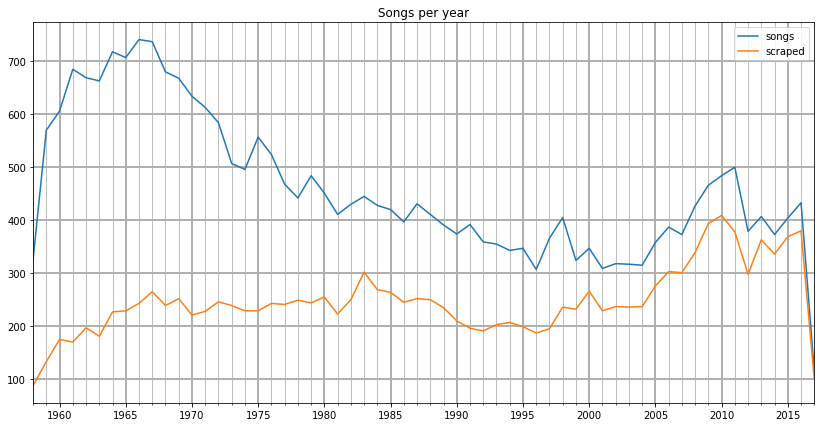

In [2]:
songs_per_year = om.groupby('year').size()
scraped_per_year = lyrs.groupby('year').size()
fig, ax = plt.subplots(figsize=(14, 7))
yrs = songs_per_year.index
ax.plot(songs_per_year.index, songs_per_year.values, label='songs')
ax.plot(scraped_per_year.index, scraped_per_year.values, label='scraped')
ax.set_xticks([yr for yr in songs_per_year.index if yr%5 == 0], minor=0);
ax.set_xticks(songs_per_year.index, minor=1);
ax.grid(which='minor');
ax.grid(which='major', lw=2);
ax.set_xlim(yrs.min(), yrs.max());
ax.set_title('Songs per year')
ax.legend();

Unsurprisingly, lyrics sites have better coverage for recent years. However, this is sort of balanced out by the earlier decades having more total songs per year, i.e. more churn from week to week - surprising!
<br/><br/>
<aside><small>
I used <a href="https://github.com/guoguo12/billboard-charts">billboard.py</a> to get the chart data. Lyrics were scraped from a large lyrics site. I made some effort to exclude incomplete transcriptions (e.g. cases where subsequent instances of the chorus are just replaced with '[chorus]'), and instrumental tracks.
</small></aside>

## Measuring repetitiveness

How should we measure repetitiveness? I know a repetitive song when I hear one, but translating that intuition into an algorithm is surprisingly challenging.

One thing we might try is looking at the number of unique words in a song, as a fraction of the total number of words. But this metric would call the following lyric excerpts equally repetitive:

> Baby I don't need dollar bills to have fun tonight  
I love cheap thrills  
Baby I don't need dollar bills to have fun tonight  
I love cheap thrills
I don't need no money  
As long as I can feel the beat  
I don't need no money  
As long as I keep dancing  
  
><cite>~ Sia, Cheap Thrills</cite>

<!-- -->

> tonight I need dollar bills  
I don't keep fun  
cheap thrills long to feel money  
the bills don't need the dancing baby  
fun dollar dancing thrills the baby I need  
don't have fun  
no no don't have dancing fun tonight  
beat the can as I don't feel thrills  
love the dancing money

><cite>~ Colin Morris, Original composition</cite>

These are both 52 words long and use the same 23 word vocabulary, but the first one is clearly more repetitive, because it arranges words in a predictable, repetitive order. Our repetitiveness metric should reward repeated sequences - the longer they are, and the more often they're repeated, the better.

### Repetitiveness ≈ compressibility? 

What if we just zip each song and measure how much smaller it gets relative to the original size?

It sounds cheeky, but it turns out that the family of [Lempel-Ziv algorithms](https://en.wikipedia.org/wiki/LZ77_and_LZ78), used in many compressed formats, have a pretty natural correspondence between their performance and the "repetitiveness" of the input data.

Lempel-Ziv works by exploiting repeated sequences, which is exactly what we're interested in. It's also pretty easy to understand. The compressed version of the Sia excerpt above would look like...

    Baby I don't need dollar bills to have fun tonight
    I love cheap thrills
    {72,72}{139,13}no money
    As long as I can feel the beat{53,35}keep dancing

Where `{n,k}` tells the decompressor "go back n characters, and copy the substring of length k starting from there".

This chorus shrunk down a lot! Notice that the compressor took advantage of repeated lines, but also repeated phrases within lines ("I don't need ", "As long as I "). 

But the best part is, the next time we see this chorus, we can replace all 242 characters of it with a single "ditto". 

### Compression ratio

My repetitiveness metric will be the ratio between the raw size (in bytes) of the song and the compressed version. For example...

    $ du -b lyrics/Sia_Featuring_S-Cheap_Thrills.txt*
    1550    lyrics/Sia_Featuring_S-Cheap_Thrills.txt
    325     lyrics/Sia_Featuring_S-Cheap_Thrills.txt.gz

*Cheap Thrills* has a compression ratio of `1550 / 325 ≈ 4.8`. It compresses down to almost a fifth of its original size!

## How repetitive/compressible is pop music?

A compression ratio of 4.8 sounds pretty good, but how does that compare to other English text?

I grabbed some prose samples to compare against:

- Poynton: *The Spoils of Poynton*, an 1896 novel by Henry James
- Reddit: some Reddit comments from February 2006
- Hansard: an excerpt from debates in the Canadian House of Commons from 2001 ([source](http://www.isi.edu/natural-language/download/hansard/))

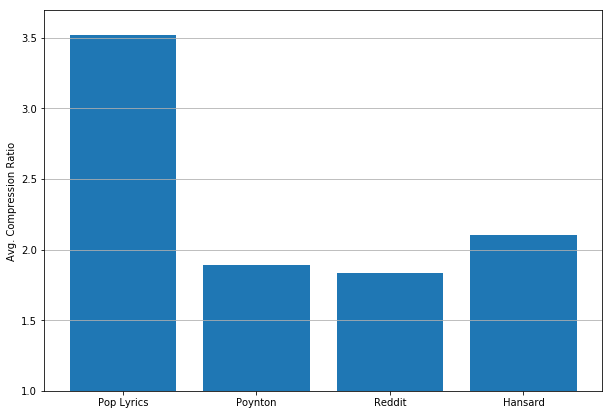

In [3]:
from IPython.display import Image
Image(filename='pop_v_prose.png')

(The Pop Lyrics ratio is the average over the 100 most recent songs in my dataset. To get comparable averages from the other datasets, I split them into 100 chunks whose sizes matched the 100 songs.)

An average pop song compresses down to about half the size of a similar-sized chunk of Henry James. Maybe if he'd written fewer lavish descriptions of furniture and more "p-p-p-poker face, p-p-poker face, muh muh muh muh", he would have sold more books.

## Notable Songs

5 outliers fall outside the histogram (0 ratios < min=1, 5 ratios > max=10)


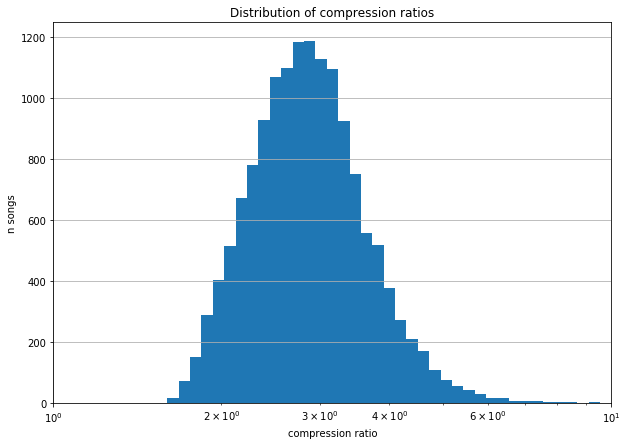

In [4]:
# XXX: experimenting
#yrs['ratio'] = lyrs['ratio'].apply(lambda r: math.log(r, 2))

xmax = 10
xmin = 1
nbins = 50
if LOG:
    bins = np.logspace(math.log(xmin,10),math.log(xmax,10),nbins)
else:
    bins = np.linspace(xmin,xmax,nbins)
ax = lyr['ratio'].hist(bins=bins, figsize=FS)
toosmall = (lyr['ratio'] < xmin).sum()
toobig = (lyr['ratio'] > xmax).sum()
print "{} outliers fall outside the histogram ({} ratios < min={}, {} ratios > max={})".format(
    toosmall+toobig, toosmall, xmin, toobig, xmax
)
ax.set_xlim(xmin, xmax);
ax.set_xlabel('compression ratio')
ax.set_ylabel('n songs');
if LOG:
    ax.set_xscale('log')
ax.set_title('Distribution of compression ratios');

This is the distribution of compression ratios over all 15,000 songs in the dataset. It looks like a log-normal distribution, in that it has a pretty Gaussian shape when the x-scale is logarithmic. (I'll be using log scales throughout for the compression ratio.)

However, there is a bit of positive skew. There are 5 songs with ratios so high that they don't fit on the chart.

Let's look at those outliers. Here are the 10 most repetitive songs:

In [5]:
n = 10
cols = ['artist', 'title', 'date', 'raw', 'comp', 'ratio']#, 'raw_ratio']
lyr[cols].sort_values(by='ratio', ascending=0).head(n)

,artist,title,date,raw,comp,ratio
25397,Daft Punk,Around The World,1997-08-30,2610.0,74.0,47.454545
4134,Fatboy Slim,The Rockafeller Skank,1998-08-08,3382.0,171.0,22.250000
15073,Jimmy Smith,Chain Of Fools (Part 1),1968-04-06,629.0,62.0,14.627907
24131,Dillon Francis & DJ Snake,Get Low,2015-04-18,1060.0,106.0,12.183908
535,Duck Sauce,Barbra Streisand,2011-05-14,1413.0,158.0,10.165468
27317,Jose Feliciano,Feliz Navidad,2017-01-07,1358.0,155.0,9.985294
6262,The Michael Zager Band,Let's All Chant,1978-03-04,1473.0,175.0,9.442308
3639,KC And The Sunshine Band,Keep It Comin' Love,1977-07-30,1824.0,214.0,9.353846
9682,Technotronic,Pump Up The Jam,1989-10-14,2714.0,323.0,8.927632
9509,Silento,Watch Me,2015-03-14,2510.0,310.0,8.625430


The top two ratios are *way* above the rest. *Around The World* compresses from 2,610 characters to 74.

All these songs jibe with my gut feelings about what a repetitive song looks like, so this makes me optimistic about using compressibility as my metric.

### Unrepetitive songs

Here are the bottom 10:

In [6]:
lyr[cols].sort_values(by='ratio', ascending=1).head(n)

,artist,title,date,raw,comp,ratio
6092,The Surfaris,Wipe Out,1963-06-22,20.0,35.0,1.250000
21100,The Beach Boys,Surfin,1962-02-17,168.0,144.0,1.344000
21704,The Yardbirds,I'm A Man,1965-10-30,249.0,183.0,1.518293
14371,James Brown,Say It Loud - I'm Black And I'm Proud (Part 1),1968-09-07,280.0,199.0,1.555556
7809,Barbra Streisand,Funny Girl,1964-09-12,391.0,263.0,1.602459
907,Chicago,Lowdown,1971-05-08,343.0,233.0,1.602804
4577,Perry Como,Tomboy,1959-02-28,439.0,292.0,1.608059
94,Stacy Lattisaw,Miracles,1983-08-13,546.0,354.0,1.629851
151,Nat King Cole,The Christmas Song (Merry Christmas To You),1960-12-17,609.0,392.0,1.632708
21486,Heart,Dreamboat Annie,1976-12-18,394.0,260.0,1.634855


Hey, did you know [Merry Christmas To You](https://genius.com/Glen-campbell-the-christmas-song-merry-christmas-to-you-lyrics) has no chorus? Mind blown.

The lyrics of all the bottom 10 are basically like that - they lack any significant repetition. 

<small>
Eagle-eyed readers may notice that the listed ratios don't quite add up. For example, the raw size of *Wipe Out*, 20 characters, divided by the compressed size of 35 bytes equals ~0.6, not 1.25. A detail I ellided is that I subtracted 18, which is the constant overhead of the gzip header+footer, from the compressed size before doing the calculation, so it wouldn't disproportionately penalize short songs.

Short songs are still a little disadvantaged by the cost of storing the huffman tables, which is not a constant overhead, but scales sub-linearly with input size. Accounting for this is tricky though.
</small>

## Is pop music getting more repetitive?

Was Donald Knuth right? 

The ranking of songs above already gives some circumstantial evidence. Among the 10 least repetitive songs, the newest one is from 1983, and more than half precede the moon landing. On the other hand, 4 of the 10 most repetitive songs are from the current decade.

Let's look at the average over all songs in each year:

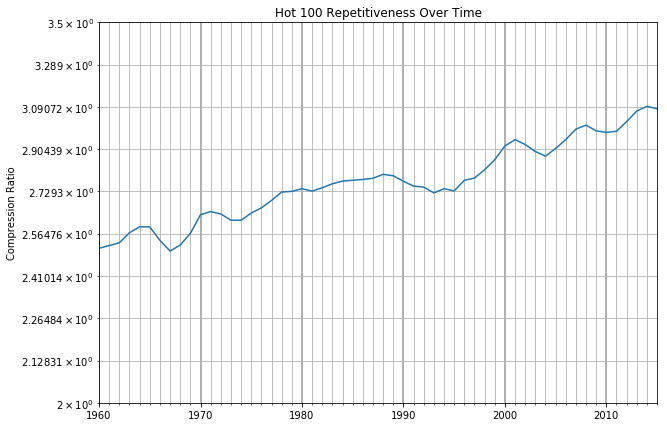

In [8]:
from scipy.stats import hmean
window_size = 3
logy = LOG
rolling = 1
use_harmonic_mean = 1
bookends = 2 # how many years to take off front and back
ihit = lyrs['peak'] <= 10
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def plot_rep_over_time(plot_hits=False, rolling=rolling):
    fig, ax = plt.subplots(figsize=FS)
    if use_harmonic_mean:
        mean_per_year = lyrs.groupby('year')['ratio'].apply(hmean)
    else:
        mean_per_year = lyrs.groupby('year')['ratio'].mean()
    if rolling:
        y = movingaverage(mean_per_year.values, window_size)
    else:
        y = mean_per_year.values
    ax.plot(mean_per_year.index, y, label='all')
    if plot_hits:
        if use_harmonic_mean:
            mean_per_year = lyrs[ihit].groupby('year')['ratio'].apply(hmean)
        else:
            mean_per_year = lyrs[ihit].groupby('year')['ratio'].mean()
        if rolling:
            y = movingaverage(mean_per_year.values, window_size)
        else:
            y = mean_per_year.values
        ax.plot(mean_per_year.index, y, label='top10')
        ax.legend()

    ax.set_xlim(yrs.min(), yrs.max());
    every_nth_year = 10
    ax.set_xticks([yr for yr in songs_per_year.index if yr%every_nth_year == 0], minor=0);
    ax.set_xticks(songs_per_year.index, minor=1);
    # 2017 has very little data. Stop 2 years before that, so that there's always a full
    # year of data to convolve with for the next and previous years.
    ax.set_xlim(1960, 2015)
    ymin = 2
    ymax = 3.5
    if logy:
        ax.set_yscale('log')
        ax.set_ylim(ymin, ymax);
        ax.set_yticks(np.logspace(math.log(ymin,10), math.log(ymax,10), 10), minor=1)
    else:
        ax.set_ylim(ymin, ymax);
        ax.set_yticks(np.arange(ymin, ymax+.01, .5), minor=0)
        ax.set_yticks(np.arange(ymin, ymax, .1), minor=1)

    ax.grid(which='minor');
    ax.grid(which='major', lw=2);
    ax.set_title('Hot 100 Repetitiveness Over Time');
    ax.set_ylabel('Compression Ratio');
    return ax

plot_rep_over_time();

Wow! Knuth was right in 1977, and he's still right today.

<small>
For the technically inclined: I'm using the harmonic rather than the arithmetic mean, since it should be more appropriate for combining ratios. I used a rolling average with a window size of 3 years to smooth out some of the spikiness from year to year.
</small>

What if we consider just songs that cracked the top 10?

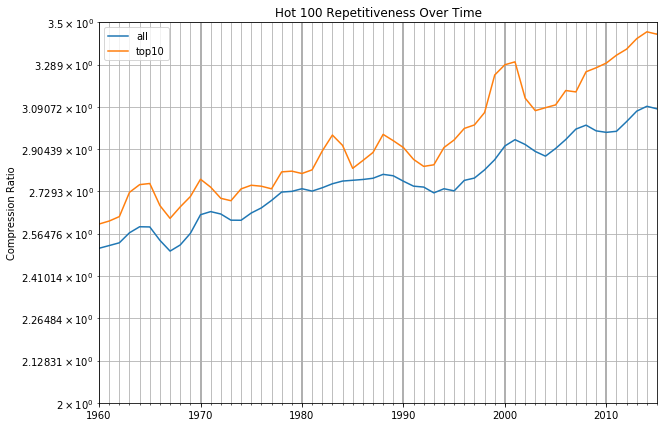

In [9]:
plot_rep_over_time(1);

It's noisier (as expected - we're averaging over fewer songs each year), but the average repetitiveness of the top 10 is *consistently* higher than the average over all songs, for every year from 1960 to 2015. Not only that, but the gulf seems to be widening over time.

(The direction of causality here is an interesting question. Is it just that repetitive songs sell more because people like them? Maybe when artists and record labels are deciding which songs to aggressively market as singles, they tend to choose more repetitive ones?)

## Who's responsible for this madness?

Are some artists worse offenders than other?

Below are the average repetition scores of a few dozen recent-ish artists having a decent number of chart entries. (I manually added broad genre annotations using Wikipedia + my judgement).

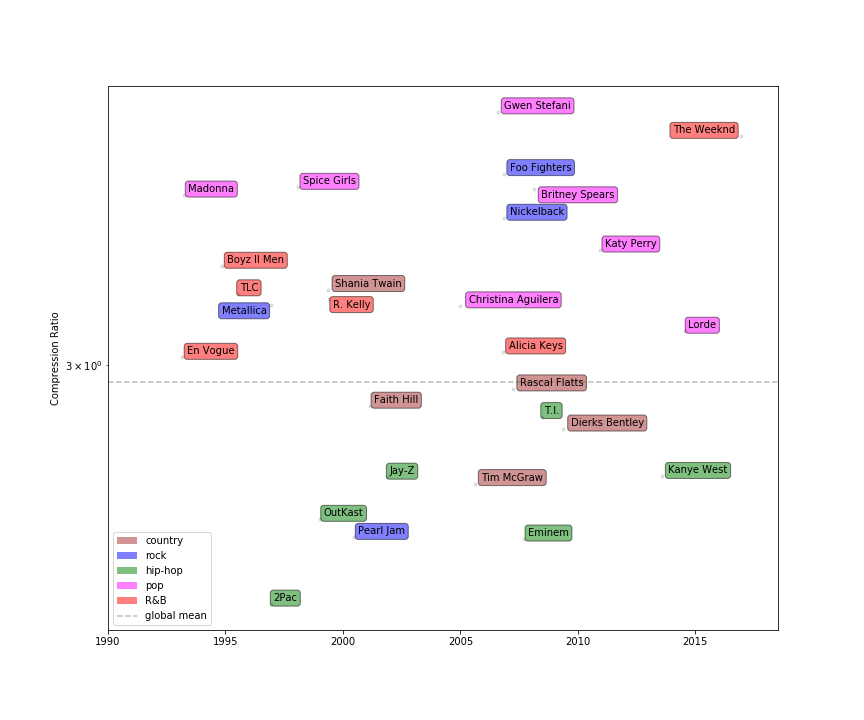

In [10]:
Image(filename='artists.png')

Pop sirens, j'accuse.

Based on this (small) sample, there seems to be a lot of variation between artists, and much of the variation seems to be explainable in terms of genre. Pop is highly repetitive, and hip-hop is the least repetitive - that seems reasonable.

How much variation is there within a single artist's discography? Let's look at an artist with a few decades of hits, Madonna:

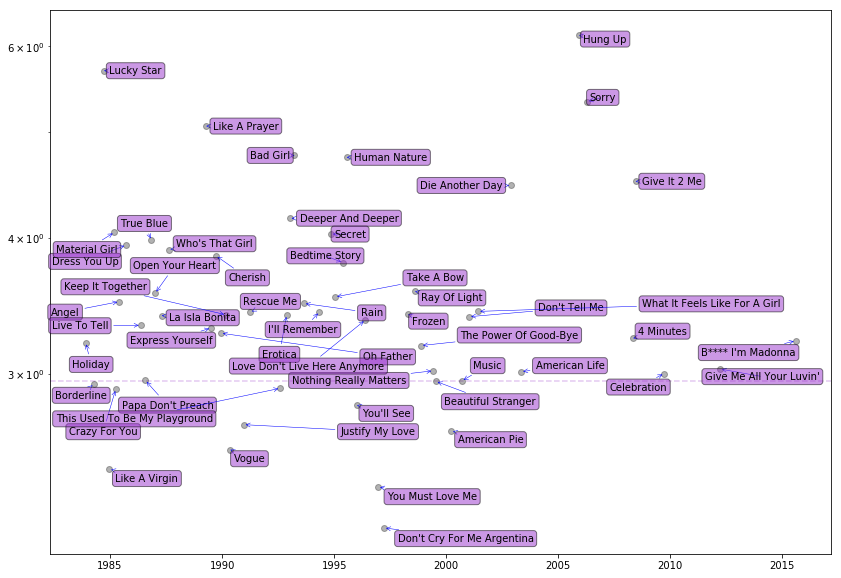

In [11]:
def plot_discography(artist, text=True, min_pos=100, logy=LOG, figsize=(14,10), include_features=1):
    fig, ax = plt.subplots(figsize=figsize)
    if include_features:
        madge = lyrs[(lyrs['artist'].str.startswith(artist)) & (lyrs['peak'] <= min_pos)]
    else:
        madge = lyrs[(lyrs['artist']==artist) & (lyrs['peak'] <= min_pos)]

    yrs = madge['yearf']
    rats = madge['ratio']
    ax.scatter(yrs, rats,color='black', alpha=.3)

    texts = []
    if text:
        for _, row in madge.iterrows():
            x = row['yearf']
            y = row['ratio']
            title = re.sub(' \(.*\)', '', row['title'])
            t = ax.text(x, y, title,
                        bbox=dict(boxstyle="round", fc='darkorchid', alpha=.5),
                        va='center',
                        #ha='center', va='center'
                       )
            texts.append(t)
        adjust_text(texts, 
                arrowprops=dict(arrowstyle="->", color='b', lw=0.5),
                autoalign='x',
        );

    global_mean = lyrs['ratio'].mean()
    line = plt.axhline(y=global_mean, color='darkorchid', label='overall mean', lw=2, linestyle='--', 
                alpha=.2, zorder=0)
    if logy:
        ax.set_yscale('log')
    return ax

plot_discography('Madonna', text=1, min_pos=100, include_features=1);

Agh, that's too many hits, Madonna! Stop being so iconic! Here's a version without the text:

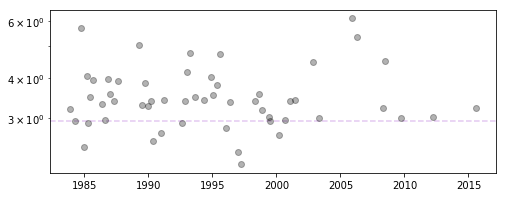

In [12]:
plot_discography('Madonna', text=0, min_pos=100, figsize=(8,3));

Well, this is pretty noisy. The data doesn't cluster obviously into albums or 'eras' as we might hope, but there are a few interesting things to note:

- 2 of her 3 most repetitive songs are from her disco-inspired 'Confessions on a Dancefloor' album. Makes sense.
- Her 2 least repetitive songs are both from Evita, and written by Andrew Lloyd Webber and Tim Rice. It makes sense that these would be outliers.
- If you squint, there's a vaguely upward trend (especially if we ignore the Evita tracks, and American Pie, a cover of a song from 1972). As the hot 100 becomes more repetitive, is Madonna making her music more repetitive to match?

Here's Taylor Swift (I'm only including songs that made it to the top 40, otherwise it would be unreadable):

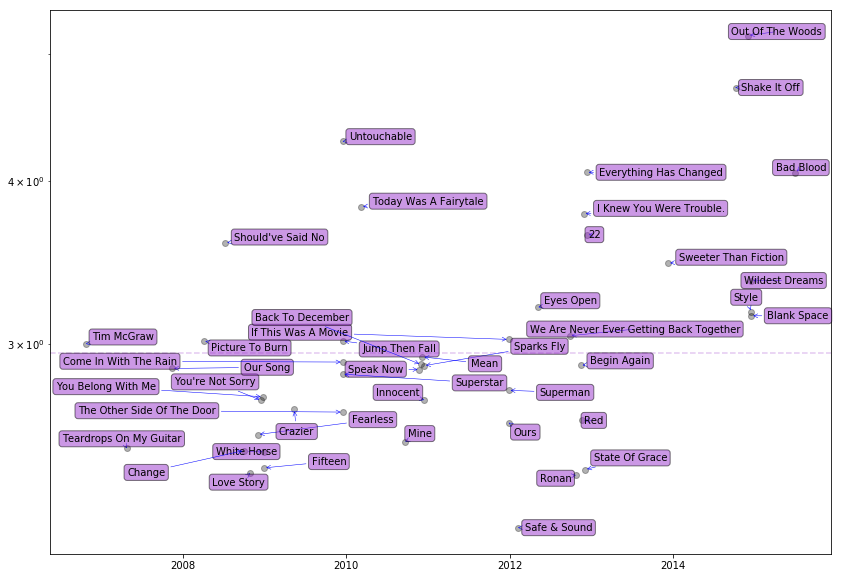

In [13]:
plot_discography('Taylor Swift', text=1, min_pos=40);

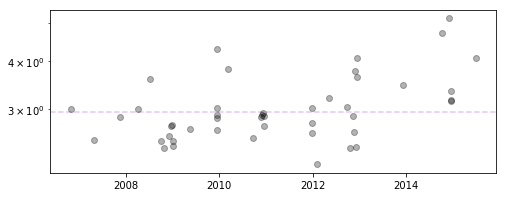

In [14]:
plot_discography('Taylor Swift', text=0, min_pos=40, figsize=(8,3));

I knew it - she totally sold out. Using the pink dashed line (the global average repetitiveness) to compare, it's clear that Swift's discography starts off way less repetitive than any part of Madonna's. Most of her songs fall below that line until late 2012, when she released "Red", and officially became a popstar. "Red" was the first album she collaborated with Max Martin on, and all three songs he co-wrote charted in the top 40, and are above the line.

With 1989, which Max Martin had his hands all over, *every* charting song is full of hooks, and well above the line.

## Are you sure about all this?

Well, uh, pretty sure. But the main caveat I should mention is that my dataset is incomplete and noisy. If the noise and missing values are biased in a particular direction, that could skew the results here. Here's one hypothetical example:

- My lyrics scraping code struggles to find matches for songs with multiple artists (e.g. "Usher Featuring Beyonce & Lil Wayne"). These songs are less likely to make it into the dataset.
- Hip-hop tracks are more likely to have featured artists
- Hip-hop is less repetitive than other genres
- Therefore, in years where there are many hip-hop tracks in the Hot 100, my estimate of the year's average repetitiveness will be biased upward.

## Can I play with the data too?

Sharing the lyrics data seems like a legal grey area, but check out [my GitHub repo](https://github.com/colinmorris/lalala). It has all the code I used to collect and patch together the data, plus all the code I used for these visualizations.